## 自己定义一个网络结构
- 更新数据读取方式

In [1]:
# Import the necessary libraries
import numpy as np
import scipy
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import glob
%matplotlib inline
#from sklearn.cross_validation import StratifiedKFold

In [2]:
# Global Variables
BATCHSZ = 32
EPOCHS = 200

In [3]:
data_dir= "E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D"
data_root = glob.glob(data_dir + '/*')
print(data_root)

['E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\data.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\data_label.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\test.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\test_label.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\train.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\train_label.npy']


In [4]:
for name in glob.glob(data_dir + '/*'):
    print(name)

E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\data.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\data_label.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\test.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\test_label.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\train.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\train_label.npy


In [5]:
train = np.load(data_root[4])
train_label = np.load(data_root[5])
test = np.load(data_root[2])
test_label = np.load(data_root[3])
train.shape, train_label.shape, test.shape, test_label.shape

((3200, 9, 9, 204), (3200,), (50929, 9, 9, 204), (50929,))

In [6]:
# Reshape data into (numberofsumples, channels, height, width)

# convert class labels to on-hot encoding
train_label = utils.to_categorical(train_label)
test_label = utils.to_categorical(test_label)
train.shape, train_label.shape, test.shape, test_label.shape

((3200, 9, 9, 204), (3200, 16), (50929, 9, 9, 204), (50929, 16))

In [7]:
train.dtype, test.dtype, train_label.dtype, test_label.dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

In [8]:
db_train = tf.data.Dataset.from_tensor_slices((train, train_label))
db_test = tf.data.Dataset.from_tensor_slices((test, test_label))

db_train = db_train.shuffle(train.shape[0]).repeat().batch(batch_size=BATCHSZ)
db_test = db_test.batch(batch_size=BATCHSZ)

In [9]:
db_train, db_test

(<BatchDataset shapes: ((None, 9, 9, 204), (None, 16)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 9, 9, 204), (None, 16)), types: (tf.float32, tf.float32)>)

In [10]:
# Define the model structure
model = tf.keras.models.Sequential()

# filters, kernels（一般小于7）， strides 默认为1， padding 默认为valid
# model.add(Conv2D(204, (1, 1), activation='relu', use_bias=False, input_shape=train[0].shape))
model.add(Conv2D(204, (1, 1), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(102, (1, 1), activation='relu', use_bias=False))
model.add(BatchNormalization())

# 9 * 9 * 204 -> 21 *21 * 204
model.add(tf.keras.layers.Conv2DTranspose(102, 3, 2,'valid', use_bias=False))
model.add(tf.keras.layers.LeakyReLU())
model.add(BatchNormalization())

# 21 * 21 * 204 -> 43 * 43 * 102
model.add(tf.keras.layers.Conv2DTranspose(64, 3, 2, 'valid', use_bias=False))
model.add(tf.keras.layers.LeakyReLU())
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', use_bias=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', use_bias=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())


model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='softmax'))

In [11]:
model.build(input_shape=(None, 9, 9, 204))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 204)         41616     
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 204)         816       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 102)         20808     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 102)         408       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 19, 19, 102)       93636     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 19, 19, 102)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 19, 19, 102)       4

In [12]:
if not os.path.exists('model_salinas'):
    os.mkdir('model_salinas')

In [13]:
# Define optimization and train method
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1)
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./model_salinas/salinas1.h5',
                                                save_best_only=True,
                                                # save_weights_only=False,
                                                monitor='val_loss')]
# checkpointer = ModelCheckpoint(filepath=".\checkP\.checkpoint.ckpt", verbose=1, save_best_only=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [14]:
BATCHSZ = 32
EPOCHS = 200

In [28]:
# Start to train model 
history = model.fit(db_train,
                    batch_size=BATCHSZ, 
                    steps_per_epoch=train.shape[0]//BATCHSZ,
                    epochs=EPOCHS, 
                    validation_data=db_test, 
                    validation_steps=test.shape[0]//BATCHSZ,
                    callbacks=[reduce_lr, callbacks])

1.4241 - val_acc: 0.5294
Epoch 19/200
100/100 [==============================] - 26s 261ms/step - loss: 0.2356 - acc: 0.8975 - val_loss: 0.7790 - val_acc: 0.7022
Epoch 20/200
100/100 [==============================] - 26s 260ms/step - loss: 0.2013 - acc: 0.9028 - val_loss: 1.8868 - val_acc: 0.5094
Epoch 21/200
100/100 [==============================] - 26s 263ms/step - loss: 0.1785 - acc: 0.9137 - val_loss: 1.3888 - val_acc: 0.6531
Epoch 22/200
100/100 [==============================] - 26s 261ms/step - loss: 0.1876 - acc: 0.9112 - val_loss: 1.4142 - val_acc: 0.6759
Epoch 23/200
100/100 [==============================] - 27s 266ms/step - loss: 0.1872 - acc: 0.9137 - val_loss: 0.6662 - val_acc: 0.7539
Epoch 24/200
100/100 [==============================] - 26s 262ms/step - loss: 0.1797 - acc: 0.9159 - val_loss: 0.5588 - val_acc: 0.7864
Epoch 25/200
100/100 [==============================] - 26s 263ms/step - loss: 0.1711 - acc: 0.9181 - val_loss: 0.3531 - val_acc: 0.7634
Epoch 26/200
100

KeyboardInterrupt: 

In [36]:
model = tf.keras.models.load_model('./model_salinas/salinas.h5')
model.build(input_shape=(None, 9, 9, 204))
model.summary()
# model.evaluate(test, test_label, batch_size=32)

ValueError: No model found in config file.

In [17]:
# # using plot_model module to save the model figure
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='./weights_salinas/model.png', show_shapes=True)

# # show the model figure
# model_img = plt.imread('./weights_salinas/model.png')
# # plt.figure(dpi=180)
# plt.imshow(model_img)
# plt.show()

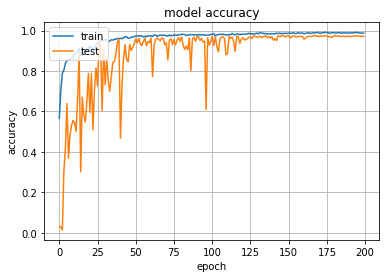

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
# plt.savefig("./result/model_accuracy_100.svg")
plt.show()

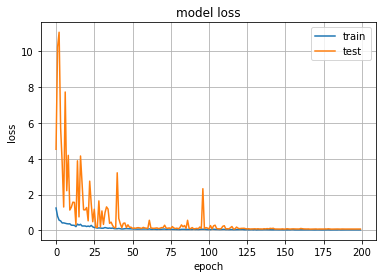

In [19]:
# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper right') 
# plt.savefig("./result/model_loss_100.svg")
plt.show()